In [1]:
import numpy as np 
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import cv2

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
 
def write_ply(fn, verts, colors):
   verts = verts.reshape(-1, 3)
   colors = colors.reshape(-1, 3)
   verts = np.hstack([verts, colors])
   with open(fn, 'w') as f:
       f.write(ply_header % dict(vert_num=len(verts)))
       np.savetxt(f, verts, '%f %f %f %d %d %d')


loading images...
(360, 640, 3)


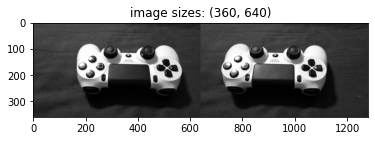

In [114]:
print('loading images...')

if False:
    imgL = cv2.pyrDown( cv2.imread('aloeR.jpg') )  # downscale images for faster processing
    imgR = cv2.pyrDown( cv2.imread('aloeL.jpg') )
else:
    tmp = cv2.imread('image-7.png',0)
#     imgL = cv2.pyrDown(tmp[:,:cols//2,:])
#     imgR = cv2.pyrDown(tmp[:,cols//2:,:])
    imgL = cv2.pyrDown(tmp[:,:cols//2])
    imgR = cv2.pyrDown(tmp[:,cols//2:])
    color = cv2.pyrDown(cv2.imread('image-7.png'))
    colors = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    _, cols = colors.shape[:2]
    colors = colors[:,:cols//2,:]
    print(colors.shape)

plt.imshow(np.hstack((imgL, imgR)), cmap="gray");
plt.title(f"image sizes: {imgL.shape}");

In [116]:
# # disparity range is tuned for 'aloe' image pair
# window_size = 3
# min_disp = 16
# num_disp = 112-min_disp
# stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#    numDisparities = num_disp,
#    blockSize = 16,
#    P1 = 8*3*window_size**2,
#    P2 = 32*3*window_size**2,
#    disp12MaxDiff = 1,
#    uniquenessRatio = 10,
#    speckleWindowSize = 100,
#    speckleRange = 32
# )

# print('computing disparity...')
# disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# print('generating 3d point cloud...')
# h, w = imgL.shape[:2]
# f = 0.8*w                          # guess for focal length
# Q = np.float32([[1, 0, 0, -0.5*w],
#                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
#                [0, 0, 0,     -f], # so that y-axis looks up
#                [0, 0, 1,      0]])
# points = cv2.reprojectImageTo3D(disp, Q)
# colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
# mask = disp > disp.min()
# out_points = points[mask]
# out_colors = colors[mask]
# out_fn = 'out.ply'
# write_ply(out_fn, out_points, out_colors)
# print(f'{out_fn} saved')

In [95]:
# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 16*1
num_disp = 16*8-min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 16,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

computing disparity...


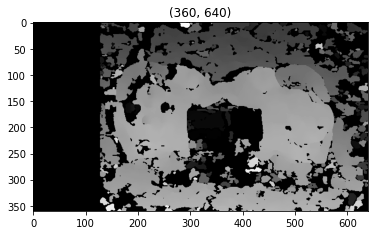

In [96]:
dm = (disp-min_disp)/num_disp
# plt.imshow(np.hstack((dm,imgR)), cmap="gray")
plt.imshow(dm, cmap="gray")
plt.title(dm.shape);

In [115]:
print('generating 3d point cloud...')
h, w = imgL.shape[:2]
t = 0.035   # baseline in meters
f = 0.8*w   # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0, 1, 0, -0.5*h],
                [0, 0, 0,      f],
                [0, 0,-1/t,    0]])
points = cv2.reprojectImageTo3D(disp, Q)
# colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]

if False:
    out_fn = 'out.ply'
    write_ply(out_fn, out_points, out_colors)
    print(f'{out_fn} saved')

generating 3d point cloud...


Reading the *ply* file with meshlab shows pretty good results:

![](ply.png)